In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "12"

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

2024-06-24 15:42:42.051115: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
from utils import (
    create_plot,
    forecast_accuracy
)

In [6]:
# Check everything with Tensorflow works 
import sys

# import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
# print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
tf.keras.utils.set_random_seed(10)
tf.config.experimental.enable_op_determinism()

Python Platform: macOS-10.16-x86_64-i386-64bit
Tensor Flow Version: 2.12.0

Python 3.9.18 (main, Sep 11 2023, 08:20:50) 
[Clang 14.0.6 ]
Pandas 2.2.1
Scikit-Learn 1.4.1.post1
SciPy 1.12.0
GPU is available


In [7]:
import keras
model = keras.models.load_model('btc_all_features_CRYPTOBERT.keras')

2024-06-24 15:42:45.752745: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-24 15:42:45.752812: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-06-24 15:42:46.274206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:42:46.275700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] 

### Loading the Dataset

In [8]:
ts_prices_btc = pd.read_csv("Data/Time_Series/prices/bitcoin_19_22.csv",index_col='date',parse_dates=['date'])

In [9]:
crypto = 'crypto_bitcoin'
# crypto = 'crypto_ethereum'
# crypto = 'crypto_xrp'

### CryptoBERT

In [10]:
model ='CRYPTOBERT'
df = pd.read_csv(f"Data/Time_Series/{crypto}/{model}_sts_19_22.csv",index_col='posted_on',parse_dates=['posted_on'])

In [11]:
ts_prices_btc= ts_prices_btc.join(df)

In [12]:
# Extracting some features from VADER sentiment time series
model ='VADER'
df_ = pd.read_csv(f"Data/Time_Series/{crypto}/{model}_sts_19_22.csv",index_col='posted_on',parse_dates=['posted_on'])
ts_prices_btc= ts_prices_btc.join(df_[['total_stopwords','average_word_length']])

In [13]:
# Remove Neutral Time Series
for c in ts_prices_btc.columns:
    if 'prop' in c.lower() or 'neutral' in c.lower():
        print(f"Dropping column {c}")
        ts_prices_btc.drop(c,axis=1,inplace=True)

Dropping column neutral_count


In [14]:
ts_prices_btc.head(4) #.shape

,price,positive_count,negative_count,total_posts,total_words,total_comments,total_stopwords,average_word_length
date,,,,,,,,
2019-01-01,3692.53,23,3,63,8369,989,3054,5.488478
2019-01-02,3794.26,35,7,90,12730,1150,4843,5.805391
2019-01-03,3872.17,44,11,113,15544,1784,5994,5.870047
2019-01-04,3776.53,31,3,95,9832,1388,3628,5.753959


In [15]:
df = ts_prices_btc

### Adding Features

In [16]:
df.head()

,price,positive_count,negative_count,total_posts,total_words,total_comments,total_stopwords,average_word_length
date,,,,,,,,
2019-01-01,3692.53,23,3,63,8369,989,3054,5.488478
2019-01-02,3794.26,35,7,90,12730,1150,4843,5.805391
2019-01-03,3872.17,44,11,113,15544,1784,5994,5.870047
2019-01-04,3776.53,31,3,95,9832,1388,3628,5.753959
2019-01-05,3815.27,17,6,57,7617,936,2835,5.877867


In [17]:
n_lags = 14
for lag in range(1, n_lags + 1):
    df[f'price_lag_{lag}'] = df['price'].shift(lag)

In [18]:
window_sizes = [7, 14, 30]  # Window sizes for moving averages
for window_size in window_sizes:
    df[f'price_ma_{window_size}'] = df['price_lag_1'].rolling(window=window_size).mean()

In [19]:
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

In [20]:
df.isna().sum()

price                   0
positive_count          0
negative_count          0
total_posts             0
total_words             0
total_comments          0
total_stopwords         0
average_word_length     0
price_lag_1             1
price_lag_2             2
price_lag_3             3
price_lag_4             4
price_lag_5             5
price_lag_6             6
price_lag_7             7
price_lag_8             8
price_lag_9             9
price_lag_10           10
price_lag_11           11
price_lag_12           12
price_lag_13           13
price_lag_14           14
price_ma_7              7
price_ma_14            14
price_ma_30            30
day_of_week             0
month                   0
year                    0
dtype: int64

In [21]:
df = df[30:]

In [22]:
test_split=round(len(df)*0.40)
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
val_split=round(len(df_for_testing)*0.50)
df_for_validation=df_for_testing[:-val_split]
df_for_testing=df[-val_split:]
print(f"Training Set: {df_for_training.shape}")
print(f"Validation Set: {df_for_validation.shape}")
print(f"Testing Set: {df_for_testing.shape}")

Training Set: (859, 28)
Validation Set: (286, 28)
Testing Set: (286, 28)


In [23]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_validation_scaled=scaler.transform(df_for_validation)
df_for_training_scaled.shape, df_for_validation_scaled.shape

((859, 28), (286, 28))

In [24]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled,30)
valX,valY=createXY(df_for_validation_scaled,30)

In [25]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(30,return_sequences=True,input_shape=(30,27)))
    grid_model.add(LSTM(30))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(valX,valY))
parameters = {'batch_size' : [16,20],
            'epochs' : [8,10],
            'optimizer' : ['adam'] }
grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

/var/folders/2l/h6ht9_t96fn33pfzbxcdp_dm0000gn/T/ipykernel_34674/1645025208.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(valX,valY))


In [26]:
grid_search = grid_search.fit(trainX,trainY)

2024-06-24 15:42:47.864631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:42:47.867631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:42:47.869473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-24 15:42:48.149030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:42:48.150694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:42:48.152202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0292

2024-06-24 15:42:55.283315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:42:55.283679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:42:55.522027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - 9s 124ms/step - loss: 0.0292 - val_loss: 0.0109
Epoch 2/8
26/26 [==============================] - 2s 78ms/step - loss: 0.0096 - val_loss: 0.0151
Epoch 3/8
26/26 [==============================] - 1s 54ms/step - loss: 0.0054 - val_loss: 0.0141
Epoch 4/8
26/26 [==============================] - 1s 39ms/step - loss: 0.0053 - val_loss: 0.0145
Epoch 5/8
26/26 [==============================] - 1s 39ms/step - loss: 0.0054 - val_loss: 0.0122
Epoch 6/8
26/26 [==============================] - 2s 71ms/step - loss: 0.0045 - val_loss: 0.0097
Epoch 7/8
26/26 [==============================] - 1s 46ms/step - loss: 0.0044 - val_loss: 0.0114
Epoch 8/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0039 - val_loss: 0.0271


2024-06-24 15:43:06.255717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:06.256094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:06.470832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - 1s 16ms/step - loss: 0.0018


2024-06-24 15:43:07.920513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:43:07.922130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:43:07.923330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-24 15:43:08.203808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:08.204198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:08.409569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - ETA: 0s - loss: 0.0028

2024-06-24 15:43:13.733618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [256,30,27]
	 [[{{node Placeholder/_10}}]]
2024-06-24 15:43:13.734001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:13.925695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

26/26 [==============================] - 7s 90ms/step - loss: 0.0028 - val_loss: 0.1519
Epoch 2/8
26/26 [==============================] - 1s 39ms/step - loss: 6.4678e-04 - val_loss: 0.1168
Epoch 3/8
26/26 [==============================] - 1s 39ms/step - loss: 3.9606e-04 - val_loss: 0.1187
Epoch 4/8
26/26 [==============================] - 1s 39ms/step - loss: 3.8874e-04 - val_loss: 0.1330
Epoch 5/8
26/26 [==============================] - 1s 39ms/step - loss: 3.5931e-04 - val_loss: 0.1428
Epoch 6/8
26/26 [==============================] - 1s 39ms/step - loss: 3.6226e-04 - val_loss: 0.1656
Epoch 7/8
26/26 [==============================] - 1s 39ms/step - loss: 2.8918e-04 - val_loss: 0.1574
Epoch 8/8
26/26 [==============================] - 1s 39ms/step - loss: 2.8297e-04 - val_loss: 0.1885


2024-06-24 15:43:22.004428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:22.004802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:22.198460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - 1s 16ms/step - loss: 0.0686


2024-06-24 15:43:23.597686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:43:23.599607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:43:23.600863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-24 15:43:23.881817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [414,30,27]
	 [[{{node Placeholder/_10}}]]
2024-06-24 15:43:23.882216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:24.086261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

26/26 [==============================] - ETA: 0s - loss: 0.0781

2024-06-24 15:43:30.606488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:30.606853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:43:31.182316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - 9s 120ms/step - loss: 0.0781 - val_loss: 0.0208
Epoch 2/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0094 - val_loss: 0.0190
Epoch 3/10
26/26 [==============================] - 26s 1s/step - loss: 0.0076 - val_loss: 0.0138
Epoch 4/10
26/26 [==============================] - 1s 57ms/step - loss: 0.0063 - val_loss: 0.0215
Epoch 5/10
26/26 [==============================] - 1s 44ms/step - loss: 0.0062 - val_loss: 0.0144
Epoch 6/10
26/26 [==============================] - 1s 47ms/step - loss: 0.0059 - val_loss: 0.0153
Epoch 7/10
26/26 [==============================] - 2s 79ms/step - loss: 0.0054 - val_loss: 0.0177
Epoch 8/10
26/26 [==============================] - 2s 55ms/step - loss: 0.0051 - val_loss: 0.0172
Epoch 9/10
26/26 [==============================] - 1s 49ms/step - loss: 0.0058 - val_loss: 0.0190
Epoch 10/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0044 - val_loss: 0.0155


2024-06-24 15:44:09.080028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:09.080395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:09.298881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - 1s 16ms/step - loss: 0.0022


2024-06-24 15:44:11.343837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:44:11.345467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:44:11.346616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-24 15:44:11.635536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:11.635981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:11.841840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - ETA: 0s - loss: 0.0018

2024-06-24 15:44:16.641304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:16.641670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:16.830677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - 6s 89ms/step - loss: 0.0018 - val_loss: 0.1808
Epoch 2/10
26/26 [==============================] - 1s 47ms/step - loss: 4.8860e-04 - val_loss: 0.1552
Epoch 3/10
26/26 [==============================] - 1s 39ms/step - loss: 3.5217e-04 - val_loss: 0.1612
Epoch 4/10
26/26 [==============================] - 1s 45ms/step - loss: 2.7165e-04 - val_loss: 0.1467
Epoch 5/10
26/26 [==============================] - 1s 41ms/step - loss: 3.1288e-04 - val_loss: 0.1531
Epoch 6/10
26/26 [==============================] - 1s 46ms/step - loss: 2.6141e-04 - val_loss: 0.1653
Epoch 7/10
26/26 [==============================] - 2s 88ms/step - loss: 2.3763e-04 - val_loss: 0.1495
Epoch 8/10
26/26 [==============================] - 1s 46ms/step - loss: 2.2984e-04 - val_loss: 0.1711
Epoch 9/10
26/26 [==============================] - 1s 38ms/step - loss: 2.4691e-04 - val_loss: 0.1621
Epoch 10/10
26/26 [==============================] - 1s 38ms/step - loss: 1.9412e-04 - v

2024-06-24 15:44:28.908157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:28.908523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:29.115115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

26/26 [==============================] - 1s 15ms/step - loss: 0.0550


2024-06-24 15:44:30.513555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:44:30.515123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:44:30.516235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-24 15:44:30.804178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:30.804571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:31.003071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

21/21 [==============================] - ETA: 0s - loss: 0.0540

2024-06-24 15:44:35.621609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:35.621979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:35.814268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

21/21 [==============================] - 7s 133ms/step - loss: 0.0540 - val_loss: 0.0110
Epoch 2/8
21/21 [==============================] - 1s 42ms/step - loss: 0.0097 - val_loss: 0.0109
Epoch 3/8
21/21 [==============================] - 1s 42ms/step - loss: 0.0075 - val_loss: 0.0106
Epoch 4/8
21/21 [==============================] - 1s 41ms/step - loss: 0.0067 - val_loss: 0.0130
Epoch 5/8
21/21 [==============================] - 1s 42ms/step - loss: 0.0065 - val_loss: 0.0135
Epoch 6/8
21/21 [==============================] - 1s 41ms/step - loss: 0.0058 - val_loss: 0.0090
Epoch 7/8
21/21 [==============================] - 1s 42ms/step - loss: 0.0052 - val_loss: 0.0129
Epoch 8/8
11/21 [==============>...............] - ETA: 0s - loss: 0.0037

2024-06-24 15:44:43.450196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:43.450590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]


21/21 [==============================] - 0s 16ms/step - loss: 0.0024


2024-06-24 15:44:43.984186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:44:43.985785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:44:43.986806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-24 15:44:44.256176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:44.256599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:44.453792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

21/21 [==============================] - ETA: 0s - loss: 0.0090

2024-06-24 15:44:49.046154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:49.046519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:49.231941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

21/21 [==============================] - 6s 112ms/step - loss: 0.0090 - val_loss: 0.3129
Epoch 2/8
21/21 [==============================] - 1s 42ms/step - loss: 0.0012 - val_loss: 0.1962
Epoch 3/8
21/21 [==============================] - 1s 42ms/step - loss: 6.1584e-04 - val_loss: 0.1796
Epoch 4/8
21/21 [==============================] - 1s 70ms/step - loss: 4.7223e-04 - val_loss: 0.1614
Epoch 5/8
21/21 [==============================] - 1s 49ms/step - loss: 4.0273e-04 - val_loss: 0.1600
Epoch 6/8
21/21 [==============================] - 1s 45ms/step - loss: 3.7304e-04 - val_loss: 0.1460
Epoch 7/8
21/21 [==============================] - 1s 42ms/step - loss: 3.6626e-04 - val_loss: 0.1470
Epoch 8/8
11/21 [==============>...............] - ETA: 0s - loss: 0.0015    

2024-06-24 15:44:57.207902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:57.208269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]


21/21 [==============================] - 1s 49ms/step - loss: 0.0712


2024-06-24 15:44:58.434813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:44:58.436394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:44:58.437483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-24 15:44:58.713952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [414,30,27]
	 [[{{node Placeholder/_10}}]]
2024-06-24 15:44:58.714366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:44:58.924551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

21/21 [==============================] - ETA: 0s - loss: 0.0350

2024-06-24 15:45:04.398574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:45:04.398951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:45:04.594569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

21/21 [==============================] - 7s 122ms/step - loss: 0.0350 - val_loss: 0.0139
Epoch 2/10
21/21 [==============================] - 1s 55ms/step - loss: 0.0109 - val_loss: 0.0110
Epoch 3/10
21/21 [==============================] - 1s 66ms/step - loss: 0.0072 - val_loss: 0.0098
Epoch 4/10
21/21 [==============================] - 1s 47ms/step - loss: 0.0073 - val_loss: 0.0089
Epoch 5/10
21/21 [==============================] - 1s 42ms/step - loss: 0.0065 - val_loss: 0.0092
Epoch 6/10
21/21 [==============================] - 1s 53ms/step - loss: 0.0063 - val_loss: 0.0081
Epoch 7/10
21/21 [==============================] - 1s 43ms/step - loss: 0.0056 - val_loss: 0.0063
Epoch 8/10
21/21 [==============================] - 1s 42ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 9/10
21/21 [==============================] - 1s 42ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 10/10
 8/21 [==========>...................] - ETA: 0s - loss: 0.0031

2024-06-24 15:45:14.981905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:45:14.982329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]


21/21 [==============================] - 0s 20ms/step - loss: 0.0031


2024-06-24 15:45:15.656289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:45:15.658037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:45:15.659110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-24 15:45:16.901858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:45:16.902307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [415]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:45:17.110329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

21/21 [==============================] - ETA: 0s - loss: 0.0022

2024-06-24 15:45:22.653746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:45:22.654116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:45:22.860754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

21/21 [==============================] - 7s 119ms/step - loss: 0.0022 - val_loss: 0.1947
Epoch 2/10
21/21 [==============================] - 1s 45ms/step - loss: 7.2422e-04 - val_loss: 0.1668
Epoch 3/10
21/21 [==============================] - 1s 42ms/step - loss: 4.6732e-04 - val_loss: 0.1753
Epoch 4/10
21/21 [==============================] - 1s 41ms/step - loss: 3.8617e-04 - val_loss: 0.1626
Epoch 5/10
21/21 [==============================] - 1s 42ms/step - loss: 3.1650e-04 - val_loss: 0.1575
Epoch 6/10
21/21 [==============================] - 1s 41ms/step - loss: 2.9949e-04 - val_loss: 0.1737
Epoch 7/10
21/21 [==============================] - 1s 41ms/step - loss: 2.8630e-04 - val_loss: 0.1574
Epoch 8/10
21/21 [==============================] - 1s 41ms/step - loss: 2.6782e-04 - val_loss: 0.1689
Epoch 9/10
21/21 [==============================] - 1s 41ms/step - loss: 2.4066e-04 - val_loss: 0.1610
Epoch 10/10
 9/21 [===========>..................] - ETA: 0s - loss: 6.1117e-04

2024-06-24 15:45:31.885813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:45:31.886185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [414]
	 [[{{node Placeholder/_11}}]]


21/21 [==============================] - 0s 17ms/step - loss: 0.0625


2024-06-24 15:45:32.468368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-24 15:45:32.469926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-24 15:45:32.470969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-24 15:45:32.756510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [829,30,27]
	 [[{{node Placeholder/_10}}]]
2024-06-24 15:45:32.756905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [829]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:45:32.955860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

52/52 [==============================] - ETA: 0s - loss: 0.0072

2024-06-24 15:45:39.072741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:45:39.073103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [256]
	 [[{{node Placeholder/_11}}]]
2024-06-24 15:45:39.265175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

52/52 [==============================] - 7s 62ms/step - loss: 0.0072 - val_loss: 0.0116
Epoch 2/10
52/52 [==============================] - 2s 35ms/step - loss: 0.0039 - val_loss: 0.0302
Epoch 3/10
52/52 [==============================] - 2s 34ms/step - loss: 0.0036 - val_loss: 0.0098
Epoch 4/10
52/52 [==============================] - 2s 36ms/step - loss: 0.0031 - val_loss: 0.0097
Epoch 5/10
52/52 [==============================] - 2s 42ms/step - loss: 0.0023 - val_loss: 0.0199
Epoch 6/10
52/52 [==============================] - 2s 36ms/step - loss: 0.0020 - val_loss: 0.0132
Epoch 7/10
52/52 [==============================] - 2s 36ms/step - loss: 0.0024 - val_loss: 0.0150
Epoch 8/10
52/52 [==============================] - 3s 60ms/step - loss: 0.0017 - val_loss: 0.0126
Epoch 9/10
52/52 [==============================] - 2s 35ms/step - loss: 0.0013 - val_loss: 0.0185
Epoch 10/10
52/52 [==============================] - 2s 35ms/step - loss: 0.0012 - val_loss: 0.0133


In [27]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}

In [28]:
my_model_all=grid_search.best_estimator_.model

In [29]:
df.shape

(1431, 28)

In [30]:
df_for_validation[-30:].shape, df_for_validation[-30:].index[0]

((30, 28), Timestamp('2022-02-19 00:00:00'))

In [31]:
df_for_testing = pd.concat([df_for_validation[-30:],df_for_testing])

In [32]:
df_for_testing.shape

(316, 28)

In [34]:
df_for_testing_scaled = scaler.transform(df_for_testing)
testX,testY=createXY(df_for_testing_scaled,30)
pred = my_model_all.predict(testX)
prediction_copies_array = np.repeat(pred,28, axis=-1)
predicted_prices = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(pred),28)))[:,0]

2024-06-24 15:46:10.453109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [286,30,27]
	 [[{{node Placeholder/_10}}]]
2024-06-24 15:46:10.453487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [286,30,27]
	 [[{{node Placeholder/_10}}]]
2024-06-24 15:46:10.740928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2

9/9 [==============================] - 1s 25ms/step


In [35]:
predicted_prices.shape

(286,)

In [36]:
df_for_testing[30:].shape

(286, 28)

In [37]:
n_df= pd.DataFrame()
n_df.index = df_for_testing.index[30:]
n_df['price'] = predicted_prices

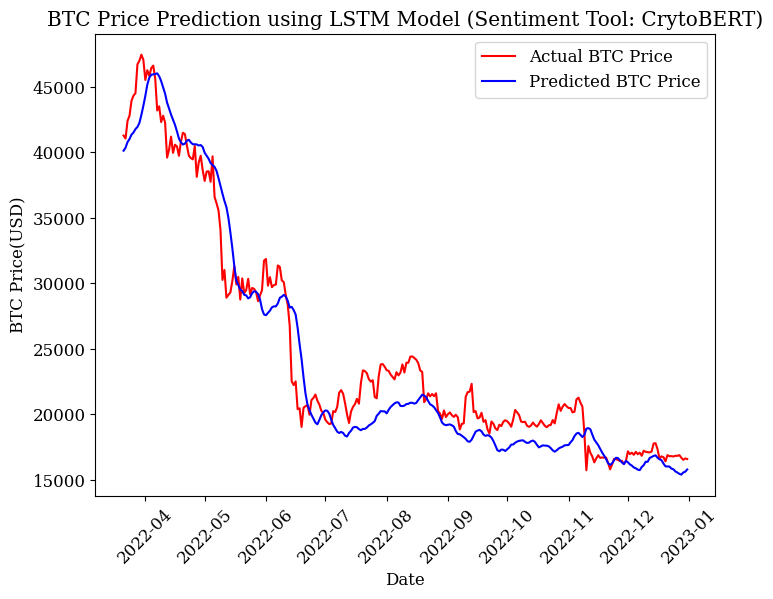

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(df_for_testing['price'].iloc[30:], color = 'red', label = 'Actual BTC Price')
plt.plot(n_df['price'], color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction using LSTM Model (Sentiment Tool: CrytoBERT)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('BTC Price(USD)')
plt.legend()
plt.show()

In [39]:
res = forecast_accuracy(n_df['price'], df_for_testing['price'].iloc[30:],['CRYPTOBERT'])
res

,MAE,MAPE,MSE,RMSE
CRYPTOBERT,1759.709016,7.397644,4.909413e+06,2215.719423


In [40]:
my_model_all.save("BTC_ModelD.keras")